2025-09-17 13:15:08.094848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758114908.302354      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758114908.364918      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



--- Initializing and Training DQN Agent ---


2025-09-17 13:15:22.728270: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


--- Prefilling replay memory with 2000 expert paths ---


Generating Expert Paths: 100%|██████████| 2000/2000 [01:11<00:00, 28.05it/s]


--- Memory prefilling complete. ---


Training DQN Agent: 100%|██████████| 10000/10000 [5:29:35<00:00,  1.98s/it]


DQN Training complete.

--- Training Complete. Preparing for final simulation. ---
Running special evaluation for Trained DQN Agent to set the benchmark...
  > Attempt 2/50 with new start/goal: (51, 61) -> (6, 25)
  > Attempt 3/50 with new start/goal: (62, 54) -> (23, 7)
  > Attempt 4/50 with new start/goal: (7, 69) -> (57, 64)
  > Attempt 5/50 with new start/goal: (15, 47) -> (64, 46)
  > Attempt 6/50 with new start/goal: (51, 17) -> (52, 65)
  > Attempt 7/50 with new start/goal: (33, 52) -> (14, 13)
  > Attempt 8/50 with new start/goal: (33, 25) -> (25, 60)
  > Attempt 9/50 with new start/goal: (11, 11) -> (21, 60)
  > Attempt 10/50 with new start/goal: (6, 66) -> (52, 19)
  > Attempt 11/50 with new start/goal: (31, 14) -> (37, 46)
  > Attempt 12/50 with new start/goal: (31, 30) -> (39, 66)
  > Attempt 13/50 with new start/goal: (57, 23) -> (17, 31)
  > Attempt 14/50 with new start/goal: (66, 57) -> (44, 11)
  > Attempt 15/50 with new start/goal: (63, 61) -> (18, 28)
  > Attempt 16/5

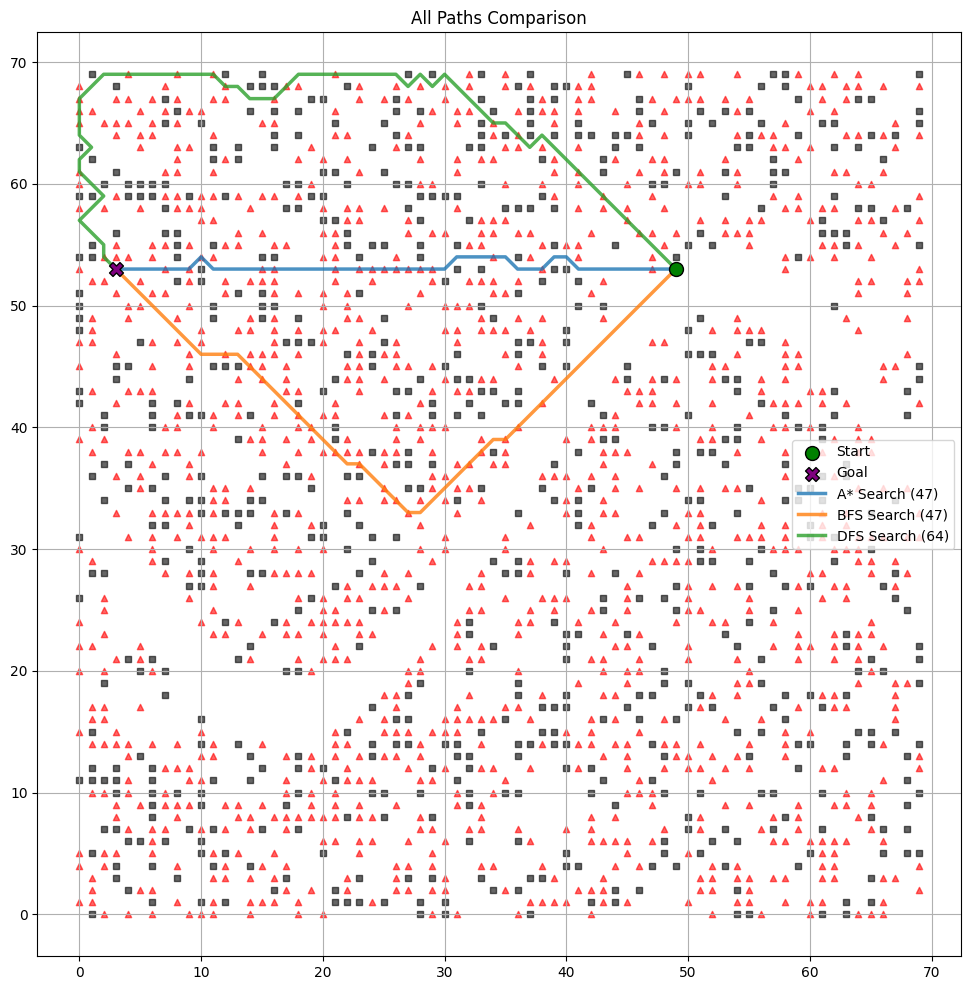

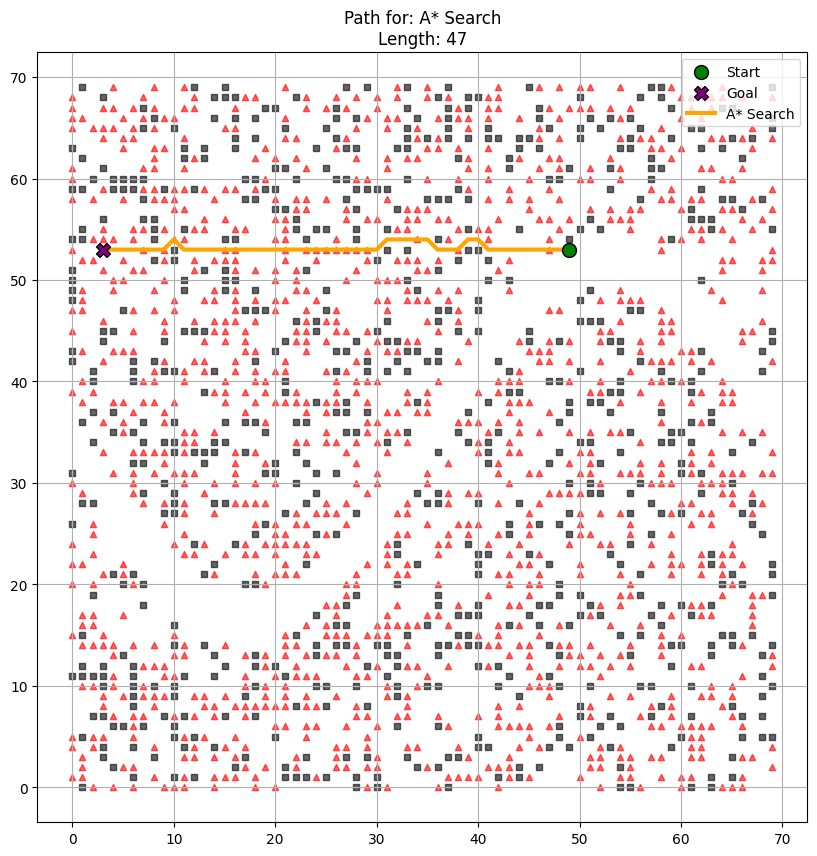

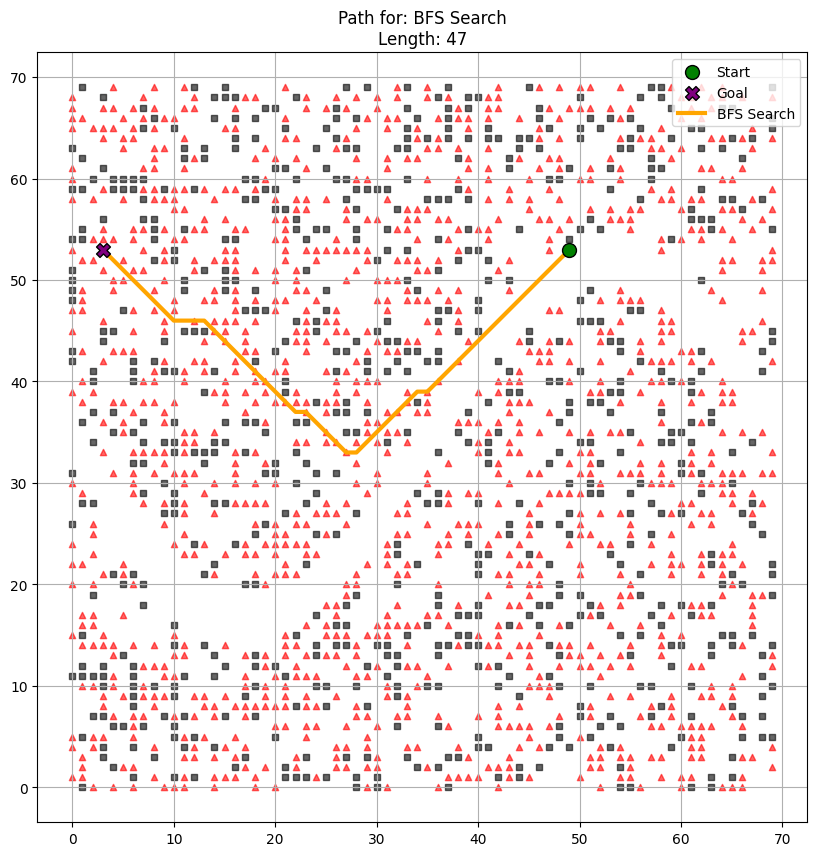

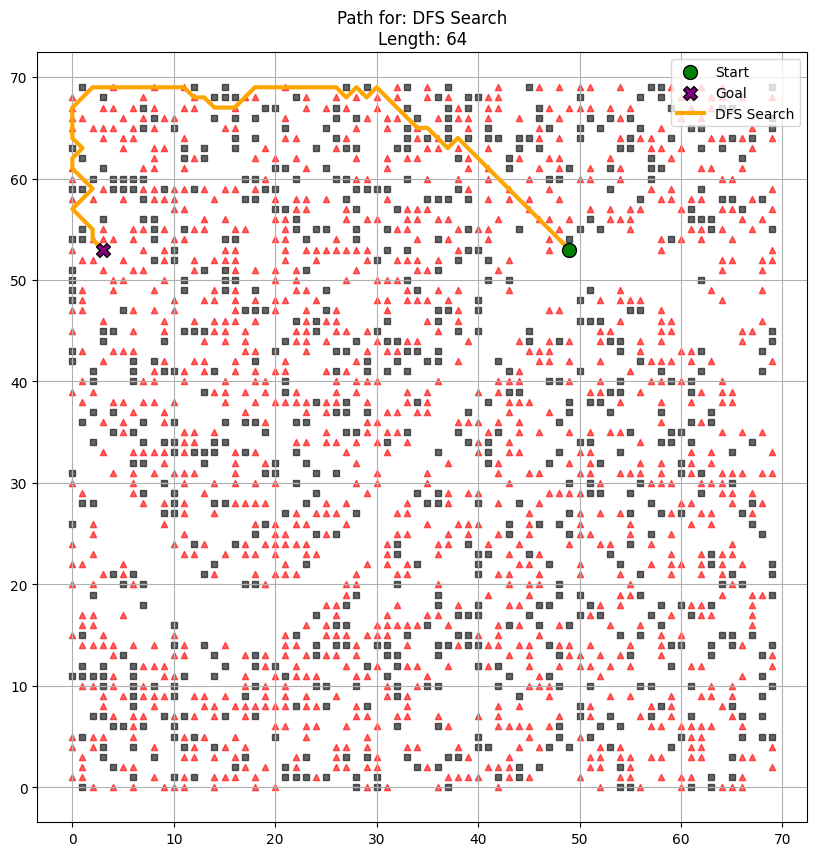

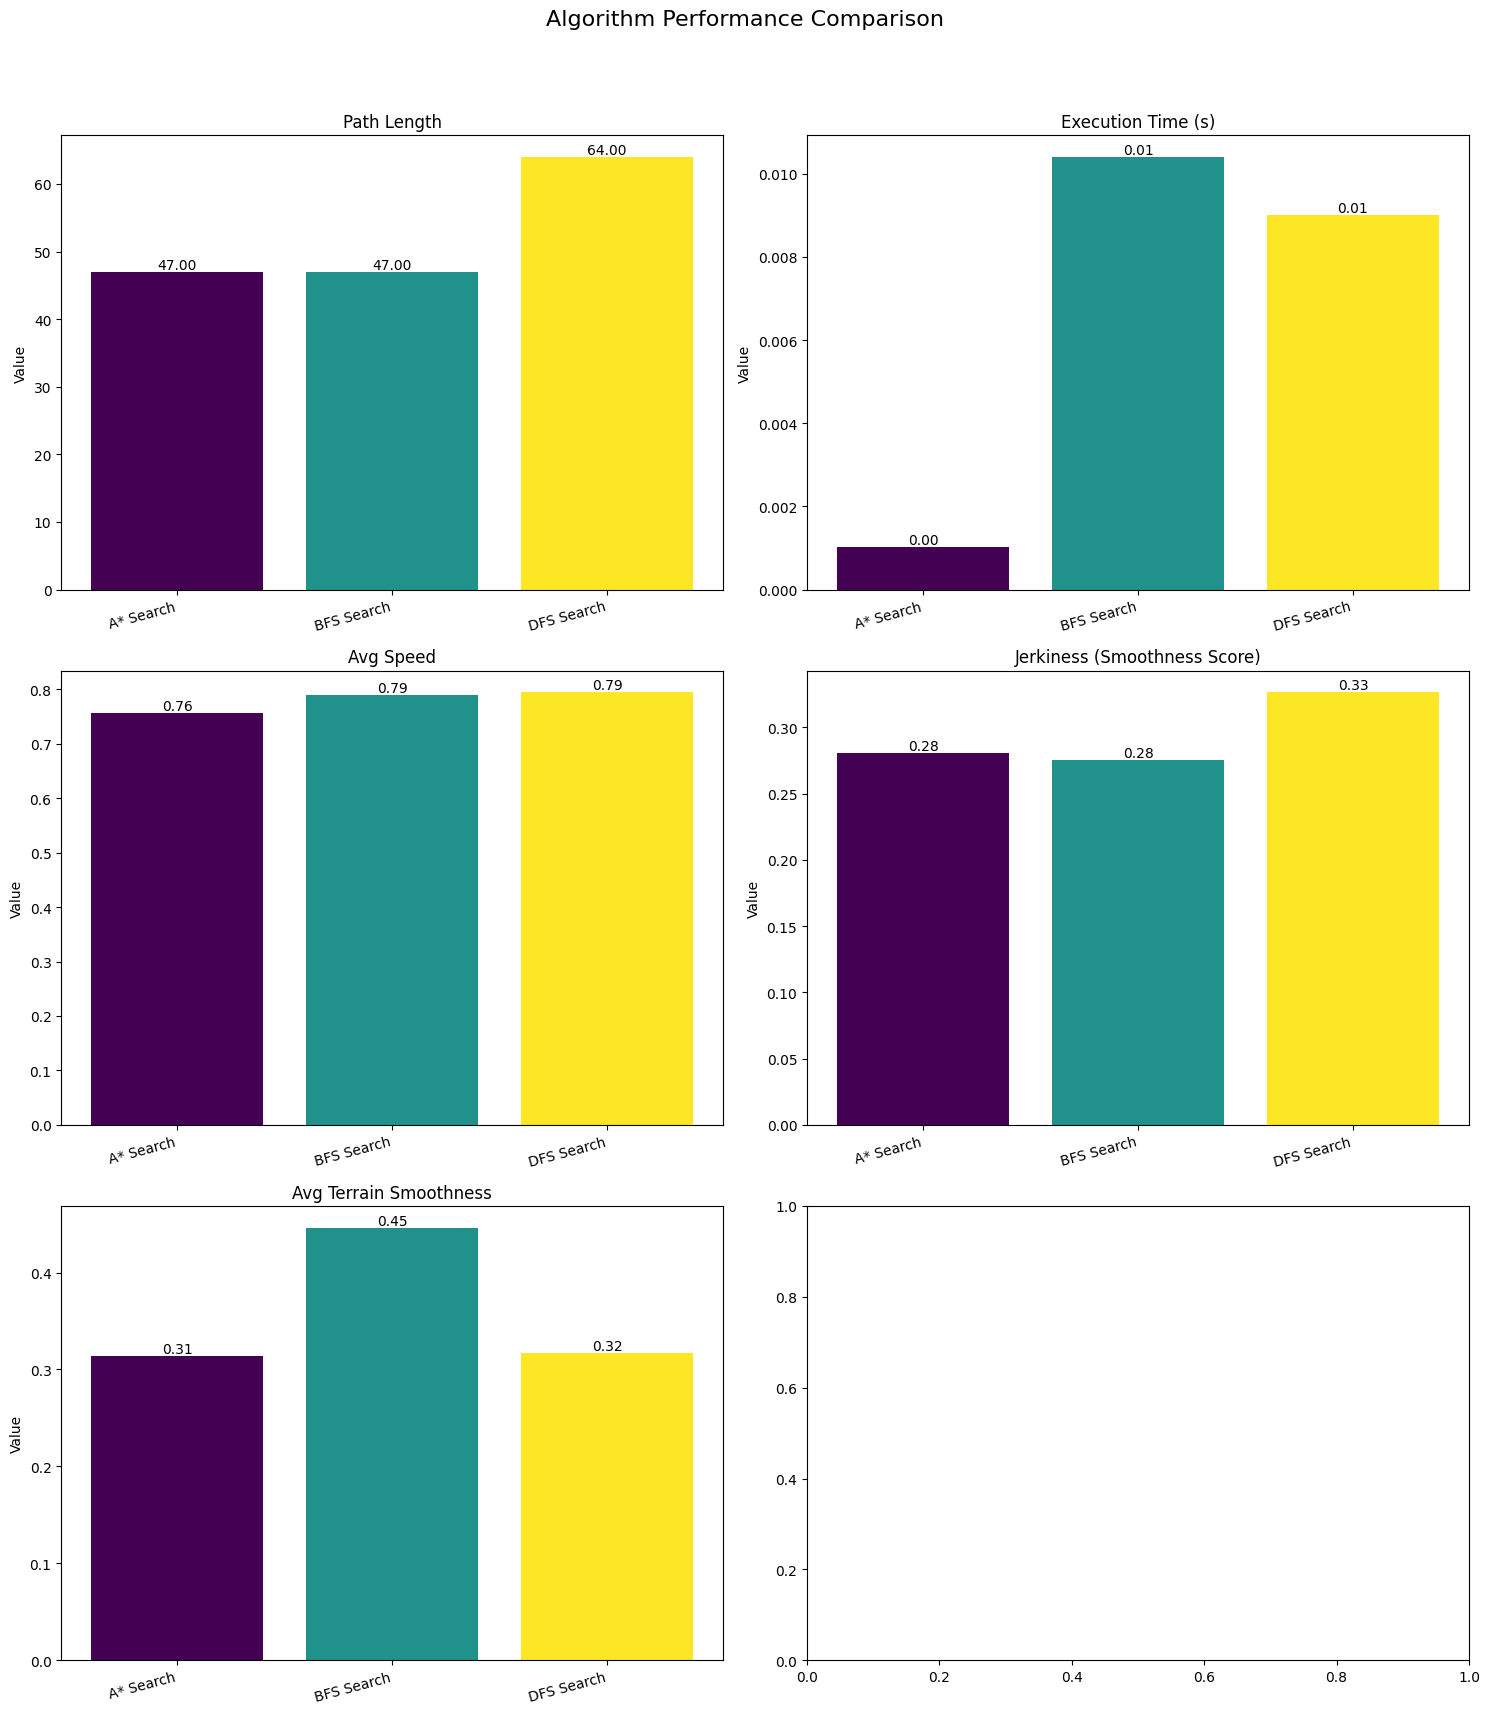


All plots have been successfully saved to the 'output_plots' directory.


In [1]:
# --- Single-file implementation with robust DQN pathfinding and retries ---
import tensorflow as tf
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import deque
from dataclasses import dataclass, field
from tqdm import tqdm
import os
import math

# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Necessary imports for the Neural Network components
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Flatten, concatenate

# --- Data Structure for Prioritized Experience Replay ---
class SumTree:
    """ A binary tree data structure for efficient priority-based sampling. """
    write = 0
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0: self._propagate(parent, change)
    def _retrieve(self, idx, s):
        left, right = 2 * idx + 1, 2 * idx + 2
        if left >= len(self.tree): return idx
        return self._retrieve(left, s) if s <= self.tree[left] else self._retrieve(right, s - self.tree[left])
    def total(self): return self.tree[0]
    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity: self.n_entries += 1
    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])

# --- Core AI Helper Functions ---
NEIGHBOR_ACTIONS = {
    0: (-1, 0), 1: (-1, 1), 2: (0, 1), 3: (1, 1),
    4: (1, 0), 5: (1, -1), 6: (0, -1), 7: (-1, -1),
}

def get_agent_state(grid, current_pos, goal, path):
    """ Creates a two-part state for the AI: a local perception vector and a 15x15x3 surroundings map. """
    rows, cols = len(grid), len(grid[0])
    perception, max_dist = [], float(rows + cols)
    for action in range(8):
        move = NEIGHBOR_ACTIONS[action]
        nr, nc = current_pos[0] + move[0], current_pos[1] + move[1]
        is_obstacle = not (0 <= nr < rows and 0 <= nc < cols) or grid[nr][nc]['obstacle']
        is_speed_breaker = 0 if is_obstacle else grid[nr][nc]['speed_breaker']
        dist_to_goal = (abs(nr - goal[0]) + abs(nc - goal[1])) / max_dist if not is_obstacle else 1.0
        is_visited = 1 if (nr, nc) in path else 0
        terrain_smoothness = 0 if is_obstacle else grid[nr][nc]['smoothness']
        perception.extend([1 if is_obstacle else 0, 1 if is_speed_breaker else 0, dist_to_goal, is_visited, terrain_smoothness])
    local_perception_vector = np.array(perception)
    
    view_size, radius = 15, 7  # Increased map view
    current_r, current_c = current_pos
    surroundings_map = np.zeros((view_size, view_size, 3))
    for r_offset in range(view_size):
        for c_offset in range(view_size):
            grid_r, grid_c = current_r - radius + r_offset, current_c - radius + c_offset
            if 0 <= grid_r < rows and 0 <= grid_c < cols:
                cell = grid[grid_r][grid_c]
                if cell['obstacle']: surroundings_map[r_offset, c_offset, 0] = 1.0
                else:
                    if cell['speed_breaker']: surroundings_map[r_offset, c_offset, 1] = 1.0
                    surroundings_map[r_offset, c_offset, 2] = (abs(grid_r - goal[0]) + abs(grid_c - goal[1])) / max_dist
            else: surroundings_map[r_offset, c_offset, 0] = 1.0
    return local_perception_vector, surroundings_map

def create_cnn_agent_brain(vector_input_shape, map_input_shape, action_size, layers=(128, 64)):
    """ Creates a multi-input Keras model with a CNN branch. """
    vector_input = Input(shape=vector_input_shape, name='vector_input')
    map_input = Input(shape=map_input_shape, name='map_input')
    conv = Conv2D(32, (3, 3), activation='relu')(map_input)
    conv = Conv2D(64, (3, 3), activation='relu')(conv)
    flat_map = Flatten()(conv)
    combined = concatenate([flat_map, vector_input])
    dense = Dense(layers[0], activation='relu')(combined)
    dense = Dense(layers[1], activation='relu')(dense)
    output = Dense(action_size, activation='linear')(dense)
    return Model(inputs=[vector_input, map_input], outputs=output)

# --- Environment and Simulation Classes ---
class GridEnvironment:
    def __init__(self, rows=30, cols=30, obstacle_prob=0.3, speed_breaker_prob=0.2, seed=None):
        self.ROWS, self.COLS = rows, cols
        self.OBSTACLE_PROB, self.SPEED_BREAKER_PROB = obstacle_prob, speed_breaker_prob
        self.NORMAL_SPEED = 1.0
        if seed is not None: random.seed(seed); np.random.seed(seed)
        self.grid = self.generate_grid_with_tradeoffs()
        self.start, self.goal = self.pick_start_goal()
    def generate_grid_with_tradeoffs(self):
        grid = [[{'obstacle': False, 'speed_breaker': False, 'breaker_speed': None, 'smoothness': random.uniform(0.2, 0.4)} for _ in range(self.COLS)] for _ in range(self.ROWS)]
        for x in range(self.COLS):
            y_center = int((self.ROWS/2) + (self.ROWS/4) * math.sin(x/(self.COLS/(2*math.pi))))
            for w in range(-2, 3):
                if 0 <= y_center + w < self.ROWS: grid[y_center+w][x].update({'smoothness': random.uniform(0.9, 1.0), 'speed_breaker': False})
        for r, c in np.ndindex(self.ROWS, self.COLS):
            if grid[r][c]['smoothness'] < 0.8:
                if random.random() < self.OBSTACLE_PROB: grid[r][c]['obstacle'] = True
                elif random.random() < self.SPEED_BREAKER_PROB: grid[r][c].update({'speed_breaker': True, 'breaker_speed': random.uniform(0.1, 0.5)})
        return grid
    def pick_start_goal(self):
        while True:
            start, goal = (random.randint(0, self.ROWS-1), random.randint(0, self.COLS-1)), (random.randint(0, self.ROWS-1), random.randint(0, self.COLS-1))
            if start != goal and not self.grid[start[0]][start[1]]['obstacle'] and not self.grid[goal[0]][goal[1]]['obstacle'] and abs(start[0]-goal[0])+abs(start[1]-goal[1]) > (self.ROWS/2):
                return start, goal
    def get_state_for_pathfinder(self): return self.grid, self.start, self.goal

@dataclass
class PathResult:
    name: str; path: list=field(default_factory=list); execution_time: float=0.0; path_length: int=0; avg_speed: float=0.0; smoothness_score: float=0.0; avg_terrain_smoothness: float = 0.0

class SimulationRunner:
    def __init__(self, environment): 
        self.env = environment
        self.algorithms = {}
        self.results = []
        self.comparison_start = None
        self.comparison_goal = None
        
    def register_algorithm(self, name, func): self.algorithms[name] = func
    
    def run_all(self):
        self.results = []
        grid, initial_start, initial_goal = self.env.get_state_for_pathfinder()
        
        dqn_agent_name = "Trained DQN Agent"
        dqn_func = self.algorithms.get(dqn_agent_name)
        
        self.comparison_start, self.comparison_goal = initial_start, initial_goal
        
        if dqn_func:
            print(f"Running special evaluation for {dqn_agent_name} to set the benchmark...")
            start_time = time.time()
            result_dict = dqn_func(grid, initial_start, initial_goal)
            end_time = time.time()

            dqn_path = result_dict['path']
            self.comparison_start = result_dict['start']
            self.comparison_goal = result_dict['goal']

            if not dqn_path:
                print(f"  > {dqn_agent_name} failed to find a path. Using its last attempt for comparison.")
                self.results.append(PathResult(name=dqn_agent_name))
            else:
                result = self._calculate_metrics(dqn_agent_name, dqn_path, end_time - start_time)
                self.results.append(result)
                print(f"  > {dqn_agent_name} Path Length: {result.path_length}, Time: {result.execution_time:.4f}s")
        
        print(f"\n--- Running Fair Comparison on Grid ---\nStart: {self.comparison_start}, Goal: {self.comparison_goal}")
        
        for name, func in self.algorithms.items():
            if name == dqn_agent_name:
                continue
            
            print(f"Running: {name}...")
            start_time = time.time()
            path = func(grid, self.comparison_start, self.comparison_goal)
            end_time = time.time()
            
            if not path:
                print(f"  > {name} failed to find a path.")
                self.results.append(PathResult(name=name))
                continue
            
            result = self._calculate_metrics(name, path, end_time - start_time)
            self.results.append(result)
            print(f"  > Path Length: {result.path_length}, Time: {result.execution_time:.4f}s")
            
        print("--- Simulation Complete ---")
        return self.results
        
    def _calculate_metrics(self, name, path, exec_time):
        grid = self.env.grid; speeds = [grid[r][c]['breaker_speed'] if grid[r][c]['speed_breaker'] else self.env.NORMAL_SPEED for r, c in path]; speed_diffs = np.diff(speeds)
        path_terrain_smoothness = [grid[r][c]['smoothness'] for r, c in path]
        shape_score = 1.0
        if len(path) >= 3:
            x, y = [c for r, c in path], [r for r, c in path]
            try:
                err = np.sqrt(np.mean((np.array(y) - np.polyval(np.polyfit(x, y, 1), x))**2))
                shape_score = 1.0 / (1.0 + err)
            except (np.linalg.LinAlgError, ValueError): shape_score = 0.0
        return PathResult(name=name, path=path, execution_time=exec_time, path_length=len(path), avg_speed=np.mean(speeds) if speeds else 0, smoothness_score=np.mean(np.abs(speed_diffs)) if len(speed_diffs) > 0 else 0, avg_terrain_smoothness=np.mean(path_terrain_smoothness) if path_terrain_smoothness else 0)
    
    def _plot_base_grid(self, ax, title, start_pos, goal_pos):
        ax.set_title(title); ax.set_aspect('equal')
        for r in range(self.env.ROWS):
            for c in range(self.env.COLS):
                if self.env.grid[r][c]['obstacle']: ax.scatter(c, self.env.ROWS - r - 1, c='black', marker='s', s=20, alpha=0.6)
                elif self.env.grid[r][c]['speed_breaker']: ax.scatter(c, self.env.ROWS - r - 1, c='red', marker='^', s=20, alpha=0.6)
        
        start_r, start_c = start_pos
        goal_r, goal_c = goal_pos
        ax.scatter(start_c, self.env.ROWS - start_r - 1, c='green', s=100, label='Start', zorder=5, edgecolors='k')
        ax.scatter(goal_c, self.env.ROWS - goal_r - 1, c='purple', s=100, label='Goal', zorder=5, marker='X', edgecolors='k')
        ax.grid(True)
        
    def display_scores(self):
        if not self.results: print("No results to display."); return
        print("\n--- Algorithm Performance Scores ---")
        for res in self.results:
            print(f"\nAlgorithm: {res.name}")
            if res.path: print(f"  - Execution Time:         {res.execution_time:.4f}s\n  - Path Length:            {res.path_length} steps\n  - Average Speed:          {res.avg_speed:.2f}\n  - Jerkiness (Lower>Best):   {res.smoothness_score:.3f}\n  - Avg Terrain Smoothness: {res.avg_terrain_smoothness:.3f}")
            else: print("  - PATH NOT FOUND")
        print("------------------------------------\n")
        
    def plot_paths_on_grid(self, output_dir="."):
        if not self.results: return
        fig, ax = plt.subplots(figsize=(12, 12))
        self._plot_base_grid(ax, "All Paths Comparison", self.comparison_start, self.comparison_goal)
        for result in self.results:
            if result.path:
                pr, pc = zip(*result.path)
                ax.plot(pc, [self.env.ROWS - r - 1 for r in pr], label=f"{result.name} ({result.path_length})", linewidth=2.5, alpha=0.8)
        ax.legend(); filepath = os.path.join(output_dir, "all_paths_comparison.png"); fig.savefig(filepath, dpi=300, bbox_inches='tight'); plt.show(); plt.close(fig)
        
    def plot_individual_paths(self, output_dir="."):
        if not self.results: return
        for result in self.results:
            if not result.path: continue
            fig, ax = plt.subplots(figsize=(10, 10))
            title = f"Path for: {result.name}\nLength: {result.path_length}"
            self._plot_base_grid(ax, title, self.comparison_start, self.comparison_goal)
            pr, pc = zip(*result.path); ax.plot(pc, [self.env.ROWS - r - 1 for r in pr], linewidth=3, color='orange', label=result.name)
            ax.legend()
            filepath = os.path.join(output_dir, f"individual_path_{result.name.replace(' ', '_').lower()}.png"); fig.savefig(filepath, dpi=300, bbox_inches='tight'); plt.show(); plt.close(fig)
            
    def plot_comparison_summary(self, output_dir="."):
        valid_results = [res for res in self.results if res.path]
        if not valid_results: return
        names = [res.name for res in valid_results]; metrics = {'Path Length': [res.path_length for res in valid_results], 'Execution Time (s)': [res.execution_time for res in valid_results], 'Avg Speed': [res.avg_speed for res in valid_results], 'Jerkiness (Smoothness Score)': [res.smoothness_score for res in valid_results], 'Avg Terrain Smoothness': [res.avg_terrain_smoothness for res in valid_results]}
        fig, axes = plt.subplots(3, 2, figsize=(15, 18)); fig.suptitle('Algorithm Performance Comparison', fontsize=16); axes = axes.flatten()
        for i, (metric_name, values) in enumerate(metrics.items()):
            ax = axes[i]; bars = ax.bar(names, values, color=plt.cm.viridis(np.linspace(0, 1, len(names)))); ax.set_title(metric_name); ax.set_ylabel('Value'); ax.bar_label(bars, fmt='%.2f'); plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); filepath = os.path.join(output_dir, "performance_summary.png"); fig.savefig(filepath, dpi=300, bbox_inches='tight'); plt.show(); plt.close(fig)

# --- Traditional Pathfinding Algorithms ---
def astar_pathfinder(grid, start, goal):
    rows, cols = len(grid), len(grid[0]); open_set, came_from, g_score = [], {}, {start: 0}; heapq.heappush(open_set, (abs(start[0]-goal[0])+abs(start[1]-goal[1]), start))
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = []
            while current in came_from: path.append(current); current = came_from[current]
            path.append(start); path.reverse(); return path
        for move in NEIGHBOR_ACTIONS.values():
            neighbor = (current[0] + move[0], current[1] + move[1]); nr, nc = neighbor
            if 0 <= nr < rows and 0 <= nc < cols and not grid[nr][nc]['obstacle']:
                move_cost = 1.414 if abs(move[0])==1 and abs(move[1])==1 else 1
                tentative_g = g_score.get(current, float('inf')) + move_cost
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor], g_score[neighbor] = current, tentative_g; heapq.heappush(open_set, (tentative_g + abs(nr-goal[0])+abs(nc-goal[1]), neighbor))
    return []

def bfs_pathfinder(grid, start, goal):
    rows, cols = len(grid), len(grid[0])
    queue, came_from = deque([start]), {start: None}
    while queue:
        current = queue.popleft()
        if current == goal:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path
        r, c = current
        for move in NEIGHBOR_ACTIONS.values():
            nr, nc = r + move[0], c + move[1]
            if 0 <= nr < rows and 0 <= nc < cols and not grid[nr][nc]['obstacle'] and (nr, nc) not in came_from:
                queue.append((nr, nc))
                came_from[(nr, nc)] = current
    return []

def dfs_pathfinder(grid, start, goal):
    rows, cols = len(grid), len(grid[0])
    stack, came_from, visited = [start], {start: None}, {start}
    while stack:
        current = stack.pop()
        if current == goal:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path
        r, c = current
        for move in NEIGHBOR_ACTIONS.values():
            neighbor = (r + move[0], c + move[1])
            nr, nc = neighbor
            if 0 <= nr < rows and 0 <= nc < cols and not grid[nr][nc]['obstacle'] and neighbor not in visited:
                stack.append(neighbor)
                visited.add(neighbor)
                came_from[neighbor] = current
    return []

# --- DQN Agent and Training Logic ---
class DQNAgent:
    def __init__(self, vector_shape, map_shape, action_size=8):
        self.vector_shape, self.map_shape, self.action_size = vector_shape, map_shape, action_size
        self.memory = SumTree(20000)
        self.per_e, self.per_a, self.per_b, self.per_b_increment, self.max_td_error = 0.01, 0.6, 0.4, 0.001, 1.0
        self.gamma, self.epsilon, self.epsilon_min, self.epsilon_decay = 0.99, 1.0, 0.01, 0.995
        self.learning_rate, self.update_target_network_rate = 0.001, 10
        self.model = create_cnn_agent_brain(vector_shape, map_shape, action_size)
        self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        self.target_model = create_cnn_agent_brain(vector_shape, map_shape, action_size)
        self.update_target_model()
    def update_target_model(self): self.target_model.set_weights(self.model.get_weights())
    def remember(self, state, action, reward, next_state, done): self.memory.add(self.max_td_error, (state, action, reward, next_state, done))
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon: return random.randrange(self.action_size)
        vec_state, map_state = np.reshape(state[0], [1, *self.vector_shape]), np.reshape(state[1], [1, *self.map_shape])
        return np.argmax(self.model.predict([vec_state, map_state], verbose=0)[0])
    def replay(self, batch_size):
        if self.memory.n_entries < batch_size: return
        indices, weights, minibatch = np.empty((batch_size,), dtype=np.int32), np.empty((batch_size,), dtype=np.float32), []
        segment = self.memory.total() / batch_size
        self.per_b = min(1., self.per_b + self.per_b_increment)
        for i in range(batch_size):
            s = random.uniform(segment * i, segment * (i + 1))
            idx, p, data = self.memory.get(s)
            weights[i] = (self.memory.n_entries * p / self.memory.total())**-self.per_b
            indices[i] = idx
            minibatch.append(data)
        vec_states, map_states = np.array([i[0][0] for i in minibatch]), np.array([i[0][1] for i in minibatch])
        vec_next, map_next = np.array([i[3][0] for i in minibatch]), np.array([i[3][1] for i in minibatch])
        actions, rewards, dones = np.array([i[1] for i in minibatch]), np.array([i[2] for i in minibatch]), np.array([i[4] for i in minibatch])
        targets, next_qs = self.model.predict([vec_states, map_states], verbose=0, batch_size=batch_size), self.target_model.predict([vec_next, map_next], verbose=0, batch_size=batch_size)
        errors = np.zeros(batch_size)
        for i in range(batch_size):
            old_q = targets[i][actions[i]]
            targets[i][actions[i]] = rewards[i] if dones[i] else rewards[i] + self.gamma * np.amax(next_qs[i])
            errors[i] = abs(old_q - targets[i][actions[i]])
        for i in range(batch_size): self.memory.update(indices[i], (errors[i] + self.per_e)**self.per_a)
        self.model.train_on_batch([vec_states, map_states], targets, sample_weight=weights / weights.max())
        if self.epsilon > self.epsilon_min: self.epsilon *= self.epsilon_decay
    def find_path(self, grid, start, goal):
        path, current_pos, self.epsilon = [start], start, 0.0
        for _ in range(len(grid) * len(grid[0])):
            if current_pos == goal: return path
            state = get_agent_state(grid, current_pos, goal, path)
            vec_state, map_state = np.reshape(state[0], [1, *self.vector_shape]), np.reshape(state[1], [1, *self.map_shape])
            action = np.argmax(self.model.predict([vec_state, map_state], verbose=0)[0])
            move = NEIGHBOR_ACTIONS[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
            if 0 <= next_pos[0] < len(grid) and 0 <= next_pos[1] < len(grid[0]) and not grid[next_pos[0]][next_pos[1]]['obstacle'] and next_pos not in path:
                current_pos = next_pos; path.append(current_pos)
            else: return []
        return []

def expert_astar_pathfinder(grid, start, goal):
    rows, cols = len(grid), len(grid[0]); open_set, came_from, g_score = [], {}, {start: 0}; heapq.heappush(open_set, (abs(start[0]-goal[0])+abs(start[1]-goal[1]), start))
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = []
            while current in came_from: path.append(current); current = came_from[current]
            path.append(start); path.reverse(); return path
        for move in NEIGHBOR_ACTIONS.values():
            neighbor = (current[0] + move[0], current[1] + move[1]); nr, nc = neighbor
            if 0 <= nr < rows and 0 <= nc < cols and not grid[nr][nc]['obstacle']:
                base_cost = 1.414 if abs(move[0])==1 and abs(move[1])==1 else 1
                cell = grid[nr][nc]; terrain_cost = 1.0 / (cell['smoothness'] + 0.1)
                sb_penalty = 50.0 if cell['speed_breaker'] else 0.0
                total_cost = base_cost * terrain_cost + sb_penalty
                tentative_g = g_score.get(current, float('inf')) + total_cost
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor], g_score[neighbor] = current, tentative_g; heapq.heappush(open_set, (tentative_g + abs(nr-goal[0])+abs(nc-goal[1]), neighbor))
    return []

def prefill_memory_with_expert(agent, env, num_paths=200):
    print(f"--- Prefilling replay memory with {num_paths} expert paths ---")
    action_map = {v: k for k, v in NEIGHBOR_ACTIONS.items()}
    for _ in tqdm(range(num_paths), desc="Generating Expert Paths"):
        env.start, env.goal = env.pick_start_goal()
        path = expert_astar_pathfinder(env.grid, env.start, env.goal)
        if not path or len(path) < 2: continue
        for i in range(len(path) - 1):
            current_pos, next_pos = path[i], path[i+1]
            state = get_agent_state(env.grid, current_pos, env.goal, path[:i+1])
            action = action_map.get((next_pos[0]-current_pos[0], next_pos[1]-current_pos[1]))
            if action is None: continue
            done = next_pos == env.goal; reward = 150 if done else 5.0
            next_state = get_agent_state(env.grid, next_pos, env.goal, path[:i+2])
            agent.remember(state, action, reward, next_state, done)
    print("--- Memory prefilling complete. ---")

def train_dqn_agent(agent, env, episodes, batch_size=64):
    for e in tqdm(range(episodes), desc="Training DQN Agent"):
        env.start, env.goal = env.pick_start_goal()
        current_pos, path = env.start, [env.start]
        for _ in range(env.ROWS * env.COLS):
            state = get_agent_state(env.grid, current_pos, env.goal, path)
            action = agent.choose_action(state)
            move = NEIGHBOR_ACTIONS[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])
            done = False
            if not(0 <= next_pos[0] < env.ROWS and 0 <= next_pos[1] < env.COLS) or env.grid[next_pos[0]][next_pos[1]]['obstacle'] or next_pos in path:
                reward, done = -10, True
            elif next_pos == env.goal:
                reward, done = 150, True
            else:
                reward = (abs(env.goal[0]-current_pos[0])+abs(env.goal[1]-current_pos[1])) - (abs(env.goal[0]-next_pos[0])+abs(env.goal[1]-next_pos[1]))
                cell = env.grid[next_pos[0]][next_pos[1]]
                reward += cell['smoothness'] * 2
                if cell['speed_breaker']: reward -= 5.0
                reward -= 0.1
            next_state = get_agent_state(env.grid, next_pos, env.goal, path + [next_pos])
            agent.remember(state, action, reward, next_state, done)
            current_pos = next_pos; path.append(current_pos)
            if done: break
        agent.replay(batch_size)
        if e > 0 and e % agent.update_target_network_rate == 0: agent.update_target_model()
    print("DQN Training complete.")

def find_path_with_retries(agent_find_path_func, grid, start, goal, max_retries=20):
    """
    Wrapper to give the agent multiple attempts.
    Returns a dictionary with the path and the specific start/goal used.
    """
    dummy_env = GridEnvironment(rows=len(grid), cols=len(grid[0]), seed=random.randint(0, 10000)); dummy_env.grid = grid
    
    current_start, current_goal = start, goal
    for attempt in range(max_retries):
        if attempt > 0:
            current_start, current_goal = dummy_env.pick_start_goal()
            print(f"  > Attempt {attempt+1}/{max_retries} with new start/goal: {current_start} -> {current_goal}")
        
        path = agent_find_path_func(grid, current_start, current_goal)
        if path:
            print(f"  > Path found on attempt {attempt+1}.")
            return {'path': path, 'start': current_start, 'goal': current_goal}
            
    print(f"  > Agent failed to find a path after {max_retries} attempts.")
    # Return the last attempted start/goal even on failure
    return {'path': [], 'start': current_start, 'goal': current_goal}

def main():
    """Main function to run the DQN training and simulation pipeline."""
    OUTPUT_DIR = "output_plots"; os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # --- Main Control Parameters ---
    SIMULATION_PARAMETERS = {'rows': 70, 'cols': 70, 'obstacle_prob': 0.15, 'speed_breaker_prob': 0.3, 'seed': 42}
    TRAINING_EPISODES = 10000
    EXPERT_PATHS = 2000
    FINAL_TEST_RETRIES = 50
    
    VECTOR_SHAPE, MAP_SHAPE, ACTION_SIZE = (8 * 5,), (15, 15, 3), 8
    
    environment = GridEnvironment(**SIMULATION_PARAMETERS)
    
    print("\n--- Initializing and Training DQN Agent ---")
    dqn_agent = DQNAgent(VECTOR_SHAPE, MAP_SHAPE, ACTION_SIZE)
    prefill_memory_with_expert(dqn_agent, environment, num_paths=EXPERT_PATHS)
    train_dqn_agent(agent=dqn_agent, env=environment, episodes=TRAINING_EPISODES, batch_size=64)
    
    print("\n--- Training Complete. Preparing for final simulation. ---")
    runner = SimulationRunner(environment)
    runner.register_algorithm("A* Search", astar_pathfinder)
    runner.register_algorithm("BFS Search", bfs_pathfinder)
    runner.register_algorithm("DFS Search", dfs_pathfinder)
    
    robust_pathfinder = lambda g, s, g_end: find_path_with_retries(dqn_agent.find_path, g, s, g_end, max_retries=FINAL_TEST_RETRIES)
    runner.register_algorithm("Trained DQN Agent", robust_pathfinder)
    
    results = runner.run_all()
    
    if results:
        runner.display_scores()
        runner.plot_paths_on_grid(output_dir=OUTPUT_DIR)
        runner.plot_individual_paths(output_dir=OUTPUT_DIR)
        runner.plot_comparison_summary(output_dir=OUTPUT_DIR)
        print(f"\nAll plots have been successfully saved to the '{OUTPUT_DIR}' directory.")
    else:
        print("No results were generated, skipping plotting.")

if __name__ == '__main__':
    main()

